In [57]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
from pathlib import Path
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [27]:
# Путь к папке с данными
data_folder = Path("/content/")

In [28]:
# Загрузка данных из CSV-файла
csv_file = data_folder / "train.csv"
train_file = pd.read_csv(csv_file)

In [29]:
# Исправляем колонки, разделяя 'image_id' и 'label'
train_file[['image_id', 'label']] = train_file['image_id,label'].str.split(',', expand=True)

In [30]:
# Удаляем старую колонку 'image_id,label'
train_file.drop('image_id,label', axis=1, inplace=True)

In [31]:
# Конвертируем метки в числовой формат
train_file['label'] = train_file['label'].astype(int)

In [32]:
# Пути к изображениям, предполагая что они находятся в поддиректории 'images/' в той же директории, что и CSV-файл
image_paths = [data_folder / 'images' / fname for fname in train_file['image_id']]

In [33]:
# Загрузка и предобработка изображений
images = []
for img_path in image_paths:
    img = cv2.imread(str(img_path))
    if img is not None:
        # Изменение размера изображения до 224x224 пикселей
        img = cv2.resize(img, (224, 224))
        # Нормализация пикселей изображения
        img = img / 255.0
        images.append(img)
    else:
        # Если изображение не найдено, добавим None в список
        images.append(None)

In [34]:
# Преобразуем список в numpy массив для последующей обработки
images = np.array([img for img in images if img is not None])

In [35]:
# Получаем метки классов
labels = train_file['label'].values

# Преобразуем метки в one-hot encoded вектора, если используется категориальная кросс-энтропия
num_classes = labels.max() + 1  # Предполагаем, что классы идут от 0 до max(label)
labels = keras.utils.to_categorical(labels, num_classes=num_classes)

In [36]:
# Удаляем None элементы из labels, соответствующие отсутствующим изображениям
valid_indices = [i for i, img in enumerate(images) if img is not None]
labels = labels[valid_indices]

# Разделим данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [38]:
# Загрузка предварительно обученной модели EfficientNetB0
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Заморозка слоёв

16705208/16705208 [==============================] - 0s 0us/step


In [39]:
# Добавление кастомных слоёв
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

In [41]:
# Сборка модели
model = Model(inputs=base_model.input, outputs=predictions)

# Компиляция модели
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [42]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 224, 224, 3)          0         ['normalization[0][0]'] 

In [44]:
# Определение коллбека для ранней остановки
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Запуск обучения модели
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/50
6/6 [==============================] - 26s 3s/step - loss: 1.3505 - accuracy: 0.5607 - val_loss: 1.3307 - val_accuracy: 0.5682
Epoch 2/50
6/6 [==============================] - 20s 4s/step - loss: 1.2856 - accuracy: 0.5723 - val_loss: 1.2949 - val_accuracy: 0.5682
Epoch 3/50
6/6 [==============================] - 17s 3s/step - loss: 1.3292 - accuracy: 0.5838 - val_loss: 1.2814 - val_accuracy: 0.5682
Epoch 4/50
6/6 [==============================] - 15s 2s/step - loss: 1.3254 - accuracy: 0.5896 - val_loss: 1.3209 - val_accuracy: 0.5682
Epoch 5/50
6/6 [==============================] - 17s 3s/step - loss: 1.2736 - accuracy: 0.5896 - val_loss: 1.3383 - val_accuracy: 0.5682
Epoch 6/50
6/6 [==============================] - 15s 3s/step - loss: 1.2470 - accuracy: 0.5896 - val_loss: 1.3067 - val_accuracy: 0.5682
Epoch 7/50
6/6 [==============================] - 17s 3s/step - loss: 1.2517 - accuracy: 0.5896 - val_loss: 1.2970 - val_accuracy: 0.5682
Epoch 8/50
6/6 [==================

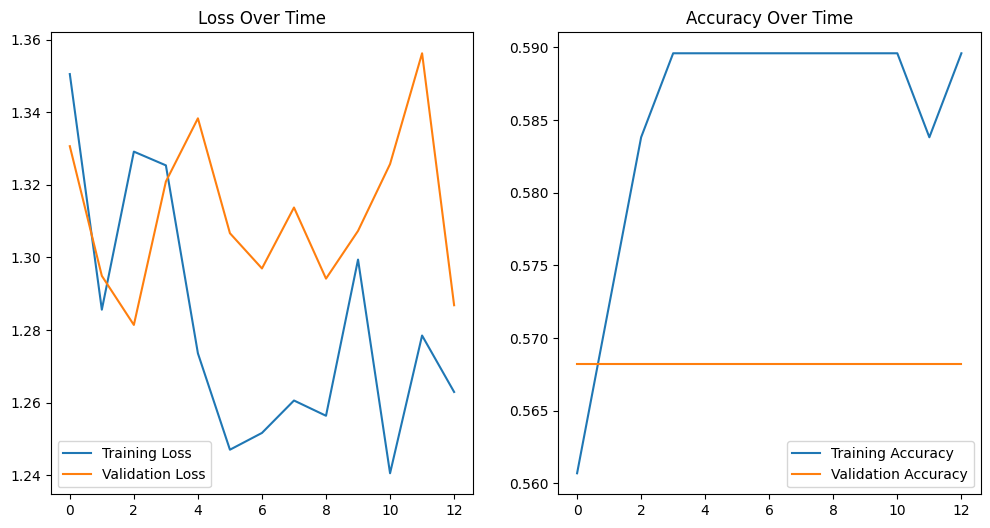

In [46]:
# Функция для отрисовки истории обучения
def plot_history(history):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Time')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Time')
    plt.legend()

    plt.show()

# Отрисовка истории обучения
plot_history(history)

In [47]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

2/2 [==============================] - 6s 2s/step - loss: 1.2814 - accuracy: 0.5682
Test Loss: 1.2814141511917114
Test Accuracy: 0.5681818127632141


In [49]:
predictions = model.predict(images)
predicted_class = np.argmax(predictions, axis=1)

7/7 [==============================] - 17s 2s/step


In [50]:
# Определение EarlyStopping колбэка
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [52]:
# Запуск процесса обучения
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    callbacks=[early_stopping]
)

val_loss, val_accuracy = model.evaluate(X_test, y_test)
print(f'Validation loss: {val_loss}, Validation accuracy: {val_accuracy}')

Epoch 1/30
6/6 [==============================] - 16s 3s/step - loss: 1.2649 - accuracy: 0.5896 - val_loss: 1.2854 - val_accuracy: 0.5682
Epoch 2/30
6/6 [==============================] - 17s 3s/step - loss: 1.2823 - accuracy: 0.5896 - val_loss: 1.3083 - val_accuracy: 0.5682
Epoch 3/30
6/6 [==============================] - 15s 3s/step - loss: 1.2898 - accuracy: 0.6069 - val_loss: 1.3204 - val_accuracy: 0.5682
Epoch 4/30
6/6 [==============================] - 19s 3s/step - loss: 1.3130 - accuracy: 0.5896 - val_loss: 1.3212 - val_accuracy: 0.5682
Epoch 5/30
6/6 [==============================] - 17s 3s/step - loss: 1.2901 - accuracy: 0.5896 - val_loss: 1.3118 - val_accuracy: 0.5682
Epoch 6/30
2/2 [==============================] - 4s 630ms/step - loss: 1.2854 - accuracy: 0.5682
Validation loss: 1.2853740453720093, Validation accuracy: 0.5681818127632141


In [54]:
# Пример разморозки последних N слоев
for layer in model.layers[-5:]:
    layer.trainable = True

In [56]:
# Перекомпиляция модели с новым оптимизатором и возможно измененной скоростью обучения
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Продолжение обучения модели
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

Epoch 1/10
6/6 [==============================] - 30s 3s/step - loss: 1.3354 - accuracy: 0.5896 - val_loss: 1.3375 - val_accuracy: 0.5682
Epoch 2/10
6/6 [==============================] - 15s 3s/step - loss: 1.3363 - accuracy: 0.5549 - val_loss: 1.3122 - val_accuracy: 0.5682
Epoch 3/10
6/6 [==============================] - 18s 3s/step - loss: 1.2802 - accuracy: 0.5896 - val_loss: 1.3011 - val_accuracy: 0.5682
Epoch 4/10
6/6 [==============================] - 17s 3s/step - loss: 1.2281 - accuracy: 0.5896 - val_loss: 1.2968 - val_accuracy: 0.5682
Epoch 5/10
6/6 [==============================] - 21s 4s/step - loss: 1.2766 - accuracy: 0.5896 - val_loss: 1.3038 - val_accuracy: 0.5682
Epoch 6/10
6/6 [==============================] - 18s 3s/step - loss: 1.2806 - accuracy: 0.5896 - val_loss: 1.3044 - val_accuracy: 0.5682
Epoch 7/10
6/6 [==============================] - 15s 3s/step - loss: 1.2689 - accuracy: 0.5896 - val_loss: 1.3214 - val_accuracy: 0.5682
Epoch 8/10
6/6 [==================

In [59]:
# Callback для снижения скорости обучения
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Callback для сохранения лучшей модели
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)

# Повторное обучение с новыми параметрами и колбэками
model.fit(X_train, y_train,
          validation_data=(X_test, y_test),
          epochs=20,
          batch_size=64,
          callbacks=[reduce_lr, checkpoint])

Epoch 1/20
3/3 [==============================] - ETA: 0s - loss: 1.3036 - accuracy: 0.5896

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 18s 6s/step - loss: 1.3036 - accuracy: 0.5896 - val_loss: 1.3126 - val_accuracy: 0.5682 - lr: 0.0010
Epoch 2/20
3/3 [==============================] - 18s 6s/step - loss: 1.2530 - accuracy: 0.5896 - val_loss: 1.3139 - val_accuracy: 0.5682 - lr: 0.0010
Epoch 3/20
3/3 [==============================] - 16s 6s/step - loss: 1.2406 - accuracy: 0.5896 - val_loss: 1.3006 - val_accuracy: 0.5682 - lr: 0.0010
Epoch 4/20
3/3 [==============================] - 15s 6s/step - loss: 1.2467 - accuracy: 0.5896 - val_loss: 1.2971 - val_accuracy: 0.5682 - lr: 0.0010
Epoch 5/20
3/3 [==============================] - 18s 7s/step - loss: 1.2572 - accuracy: 0.5896 - val_loss: 1.2960 - val_accuracy: 0.5682 - lr: 0.0010
Epoch 6/20
3/3 [==============================] - 18s 6s/step - loss: 1.2312 - accuracy: 0.5896 - val_loss: 1.3014 - val_accuracy: 0.5682 - lr: 0.0010
Epoch 7/20
3/3 [==============================] - 19s 7s/step - loss: 1.2433 - accuracy: 0.5896 - val_los

In [61]:
# Оценка модели на тестовом наборе данных
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test loss: {test_loss}, Test accuracy: {test_accuracy}')

2/2 [==============================] - 5s 702ms/step - loss: 1.3105 - accuracy: 0.5682
Test loss: 1.3104870319366455, Test accuracy: 0.5681818127632141


In [72]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Сохраняем оценку производительности для сравнения
original_val_accuracy = model.evaluate(X_test, y_test)[1]

print(f'Validation accuracy with original labels: {original_val_accuracy}')

Epoch 1/10
6/6 [==============================] - 15s 3s/step - loss: 1.2488 - accuracy: 0.5896 - val_loss: 1.3098 - val_accuracy: 0.5682
Epoch 2/10
6/6 [==============================] - 17s 3s/step - loss: 1.2248 - accuracy: 0.5896 - val_loss: 1.3097 - val_accuracy: 0.5682
Epoch 3/10
6/6 [==============================] - 14s 2s/step - loss: 1.2579 - accuracy: 0.5896 - val_loss: 1.3098 - val_accuracy: 0.5682
Epoch 4/10
6/6 [==============================] - 14s 2s/step - loss: 1.2472 - accuracy: 0.5896 - val_loss: 1.3100 - val_accuracy: 0.5682
Epoch 5/10
6/6 [==============================] - 17s 3s/step - loss: 1.2698 - accuracy: 0.5896 - val_loss: 1.3101 - val_accuracy: 0.5682
Epoch 6/10
6/6 [==============================] - 15s 3s/step - loss: 1.2521 - accuracy: 0.5896 - val_loss: 1.3103 - val_accuracy: 0.5682
Epoch 7/10
6/6 [==============================] - 17s 3s/step - loss: 1.2556 - accuracy: 0.5896 - val_loss: 1.3102 - val_accuracy: 0.5682
Epoch 8/10
6/6 [==================

In [77]:
def manipulate_labels(y_train, manipulation_level):
    """
    Manipulate labels in the training set.

    Parameters:
    y_train (array): Original labels.
    manipulation_level (float): Level of manipulation, e.g., 0.05 for 5% manipulation.

    Returns:
    y_manipulated (array): Manipulated labels.
    """
    # Copy the original labels
    y_manipulated = np.copy(y_train)

    # Determine the number of labels to manipulate
    num_samples = len(y_train)
    num_manipulate = int(manipulation_level * num_samples)

    # Randomly select indices to manipulate
    manipulate_indices = np.random.choice(num_samples, size=num_manipulate, replace=False)

    # Manipulate the labels
    for idx in manipulate_indices:
        original_label = y_train[idx]
        possible_labels = [label for label in np.unique(y_train) if not np.array_equal(label, original_label)]
        y_manipulated[idx] = np.random.choice(possible_labels)

    return y_manipulated

# Define manipulation levels
manipulation_levels = [0.05, 0.1, 0.15, 0.2]  # Manipulation levels from 5% to 20%

# Loop through manipulation levels
for manipulation_level in manipulation_levels:
    # Manipulate labels
    y_train_manipulated = manipulate_labels(y_train, manipulation_level)

    # Retrain the model with manipulated labels
    history_manipulated = model.fit(X_train, y_train_manipulated, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=0)

    # Evaluate the model with manipulated labels
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

    print(f'Manipulation level: {manipulation_level * 100}%, Validation accuracy: {accuracy}')


Manipulation level: 5.0%, Validation accuracy: 0.5681818127632141
Manipulation level: 10.0%, Validation accuracy: 0.5681818127632141
Manipulation level: 15.0%, Validation accuracy: 0.5681818127632141
Manipulation level: 20.0%, Validation accuracy: 0.5681818127632141
